# Direct Query Error Analysis

When you total up the number of failures, even for models that eventually succeeded, you end up with 232 failures! Can we extract any information from these?

1. Feed each failed case (code, hints, question, stderr/stdout) to the LLM
1. Ask it to make some judgement calls about the failures.

The file [error_catalog.yaml](error_catalog.yaml) contains the raw data for analysis, and the code can be found in [analyze-failures.py](analyze-failures.py).

In [1]:
import math

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml
from questions import extract_questions

## Data Preparation

In [2]:
# error catalog
with open('error_catalog.yaml', 'r') as f:
    error_data = yaml.safe_load(f)

# Convert to pandas DataFrame
error_analysis = pd.DataFrame(error_data)

The questions are in text here, which is a little tough to deal with. So lets put them into numbers.

In [3]:
all_questions = extract_questions()
question_lookup = {q: index+1 for index, q in enumerate(all_questions)}

error_analysis['question_index'] = error_analysis['question'].map(question_lookup)

In [4]:
error_analysis.columns

Index(['error_description', 'goal', 'hint_text_suggestion', 'hint_violation',
       'iteration', 'model', 'phase', 'policy_error', 'question',
       'question_index'],
      dtype='object')

## Errors per question
Lets look at the errors and types of error per question to see what patterns emerge.

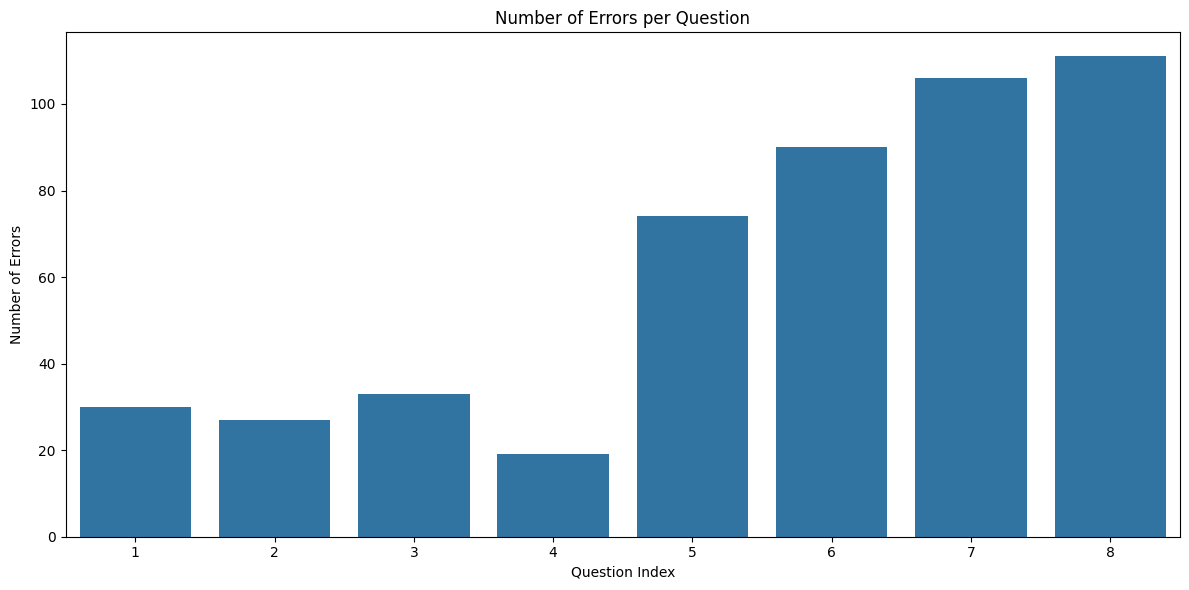

In [5]:
# Count errors per question_index
error_counts = error_analysis['question_index'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=error_counts.index, y=error_counts.values)
plt.xlabel('Question Index')
plt.ylabel('Number of Errors')
plt.title('Number of Errors per Question')
plt.tight_layout()
plt.show()

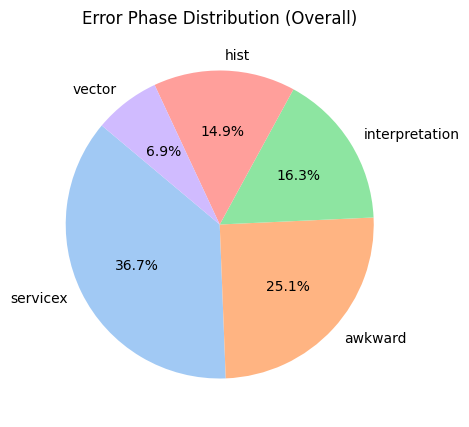

In [6]:
# Pie chart of error phases overall
phase_counts = error_analysis['phase'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(phase_counts, labels=phase_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Error Phase Distribution (Overall)')
plt.show()

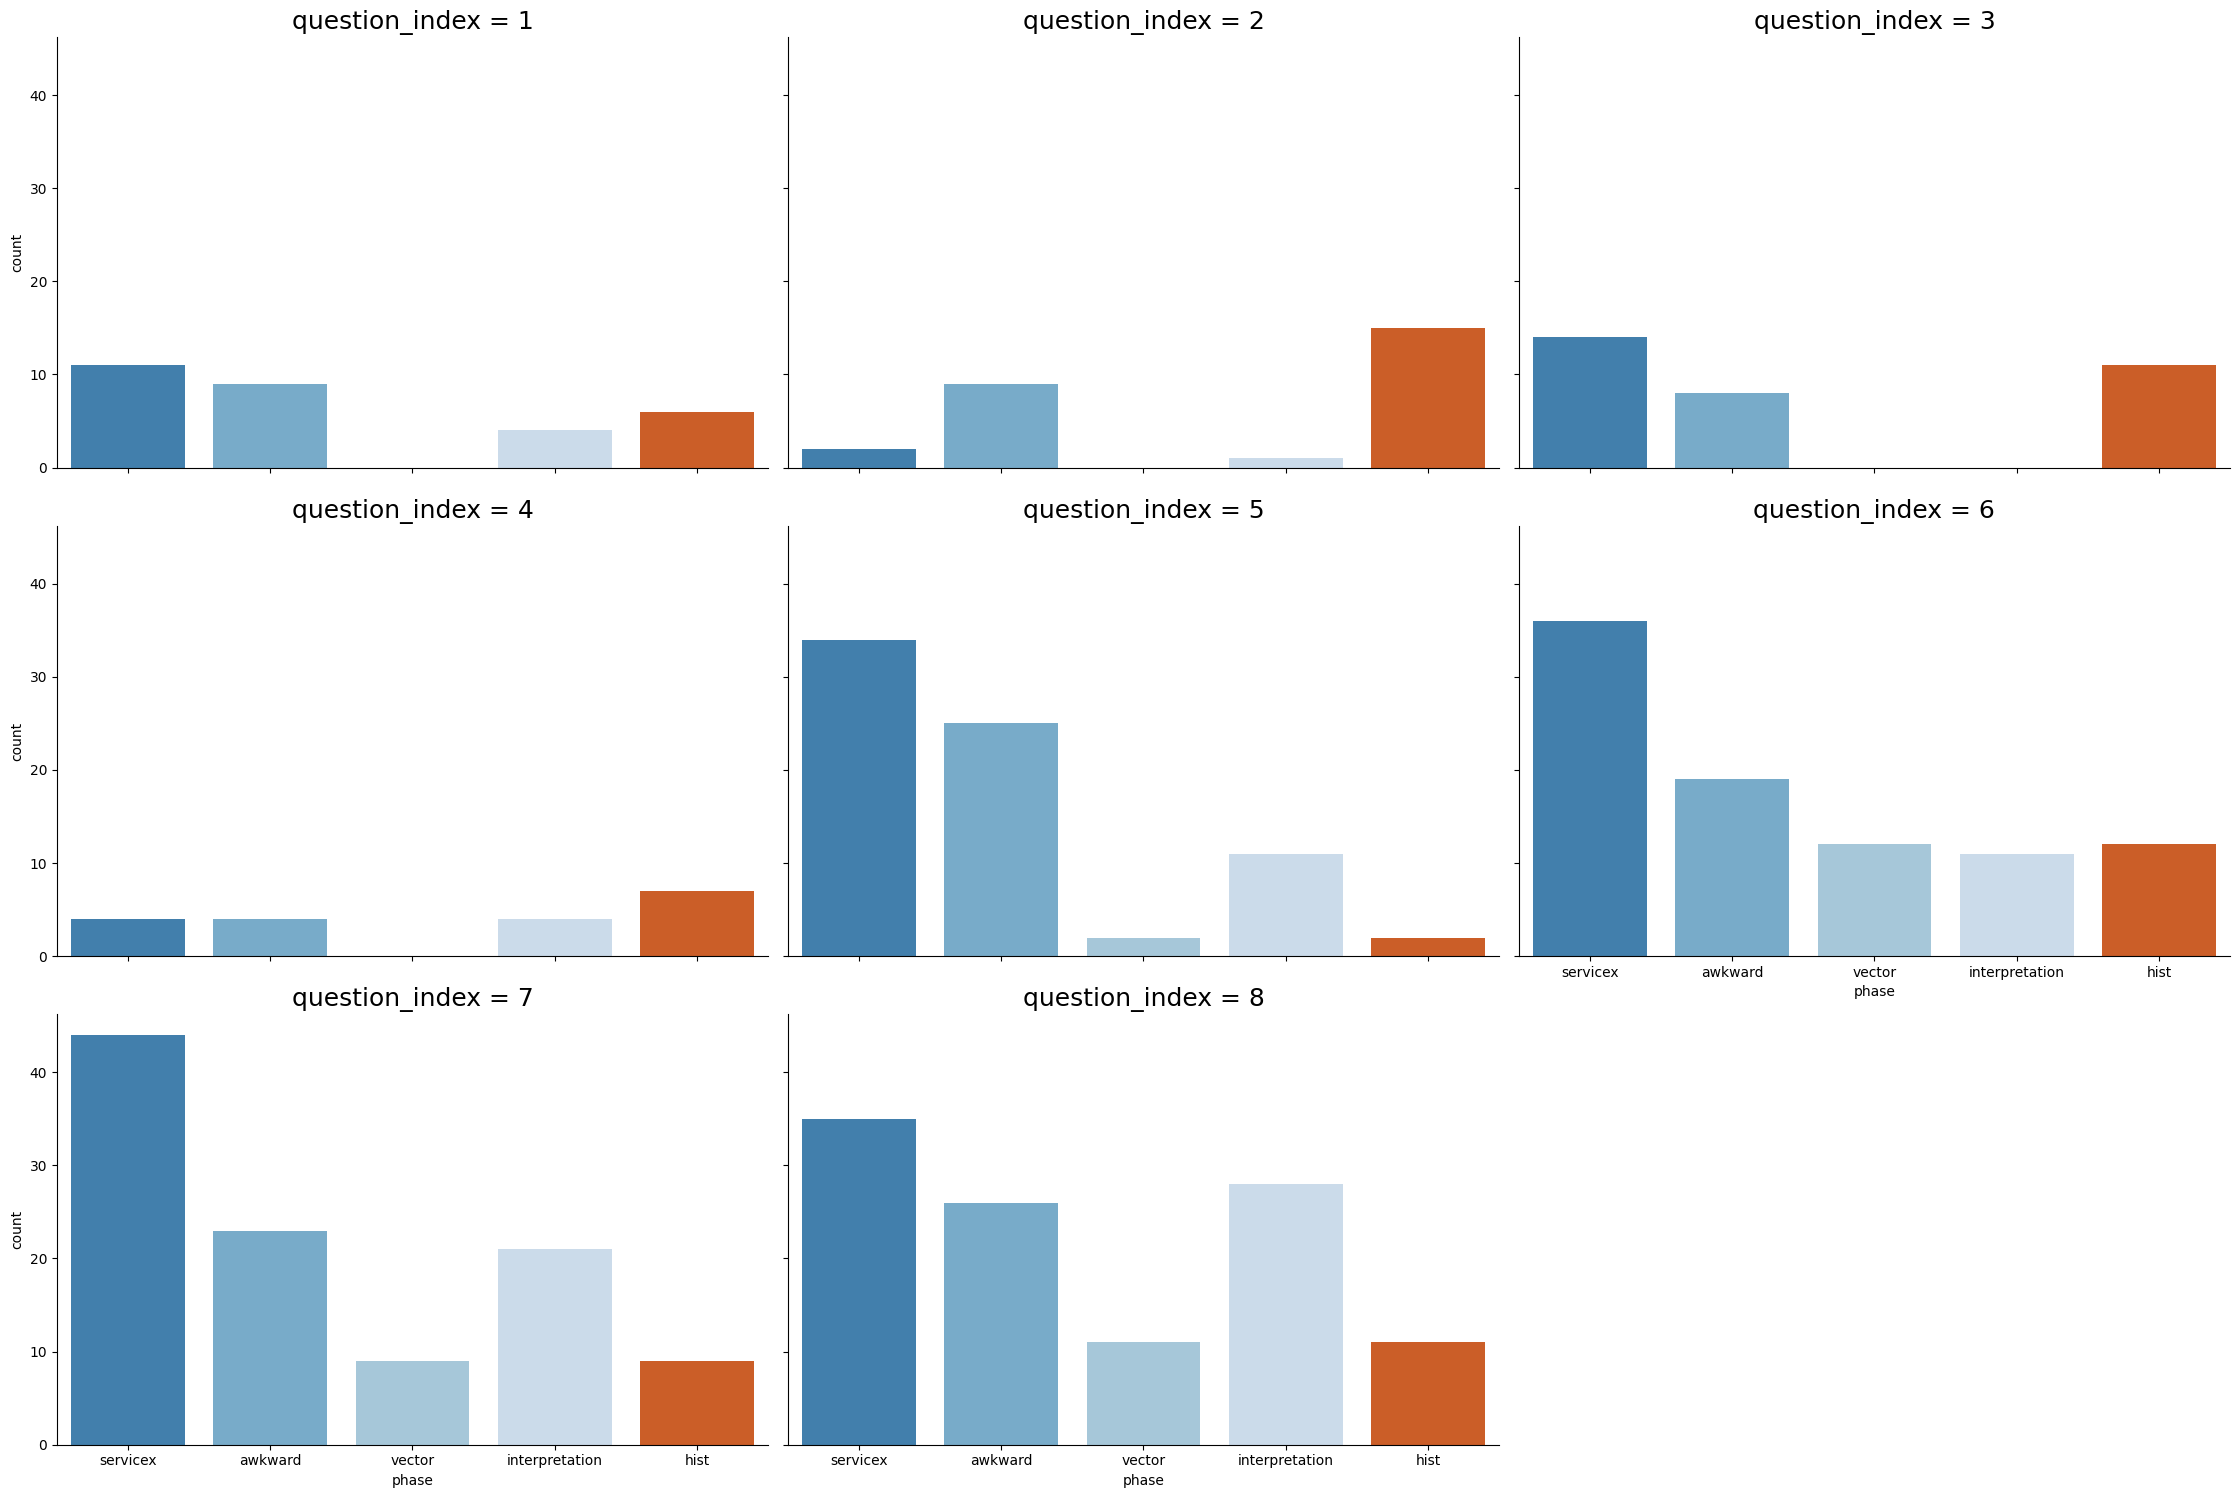

In [7]:
g = sns.catplot(
    data=error_analysis,
    x="phase",
    kind="count",
    col="question_index",
    col_wrap=3,
    palette="tab20c",
    hue="phase",
    height=5,  # Increase height of each facet
    aspect=1.5  # Increase aspect ratio for width
)
# Increase the font size for all subplot titles and axis labels uniformly
for ax in g.axes.flatten():
    if hasattr(ax, 'set_title') and hasattr(ax, 'get_title'):
        ax.set_title(ax.get_title(), fontsize=18)
plt.show()

Some observations from here:

* There is a consistent low-level number of histogram problems. They seem almost constant across questions. Perhaps there is some simple hint file update here.
* WHen we hit questions 5+, ServiceX and `awkward` become hard to use.

## Model Behavior

First, lets look at the phase distributions for each model

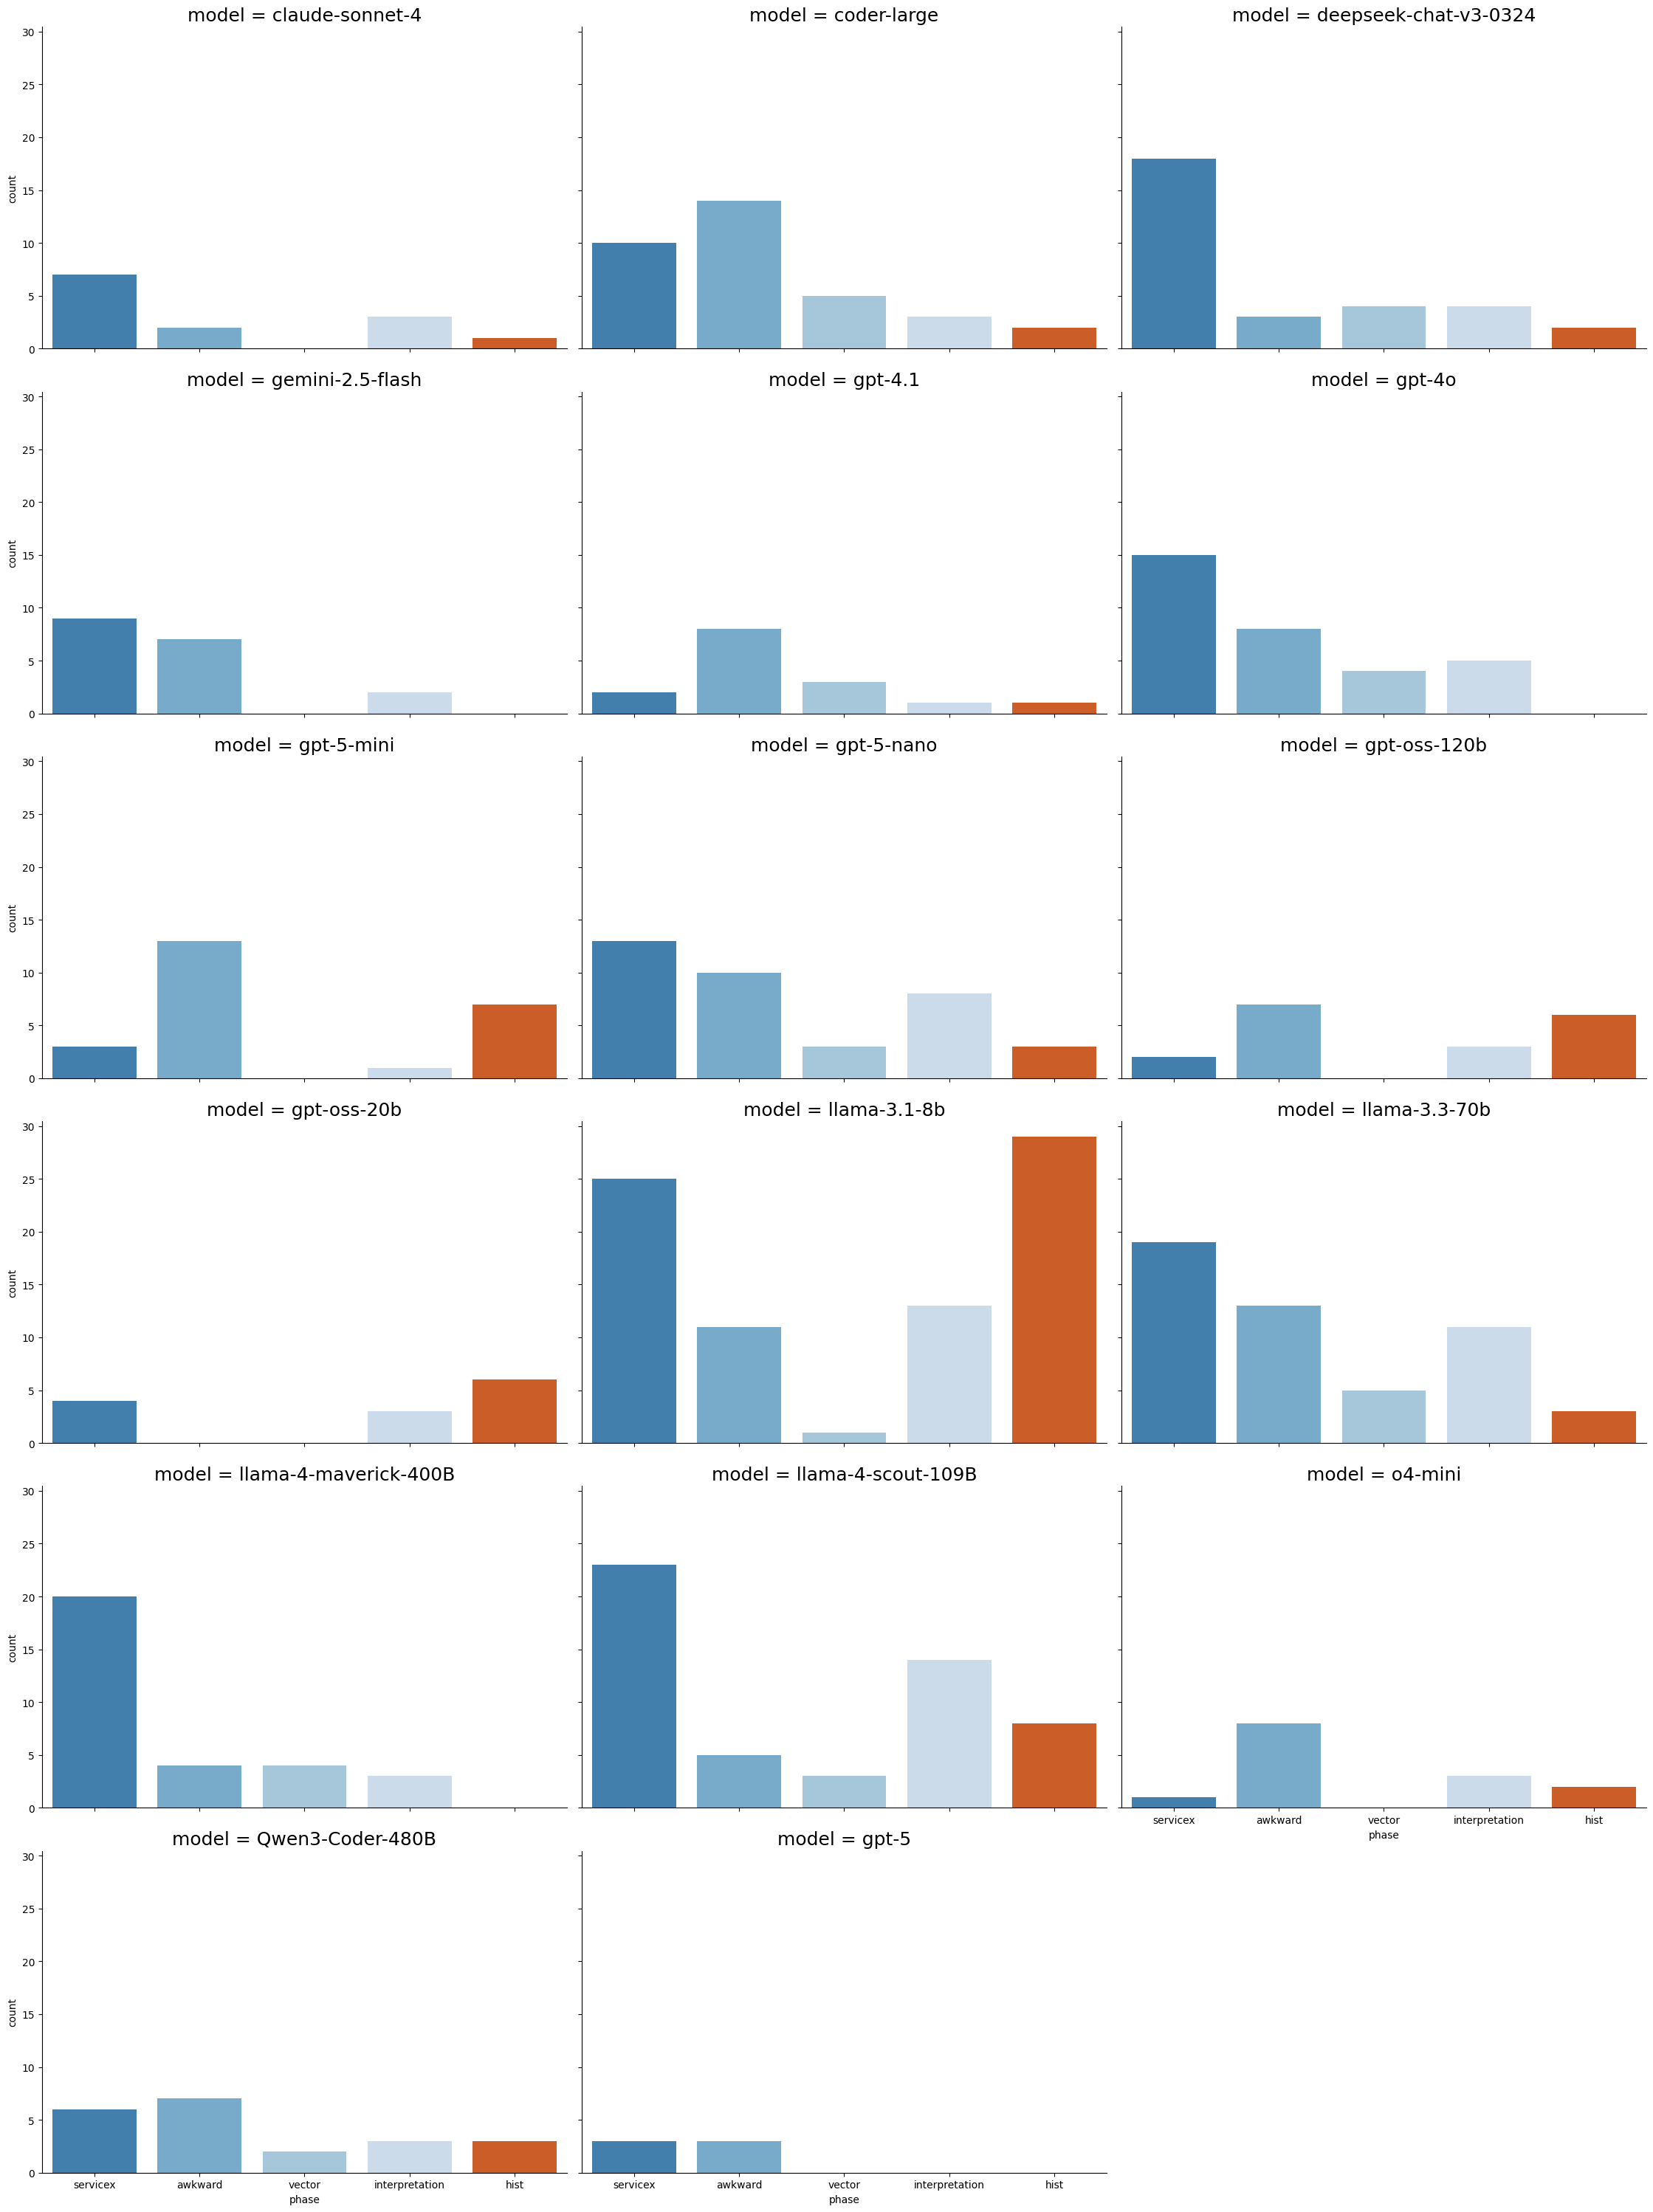

In [8]:
g = sns.catplot(
    data=error_analysis,
    x="phase",
    kind="count",
    col="model",
    col_wrap=3,
    palette="tab20c",
    hue="phase",
    height=5,  # Increase height of each facet
    aspect=1.5  # Increase aspect ratio for width
)
# Increase the font size for all subplot titles and axis labels uniformly
for ax in g.axes.flatten():
    if hasattr(ax, 'set_title') and hasattr(ax, 'get_title'):
        ax.set_title(ax.get_title(), fontsize=18)
plt.show()

Some observations from that:

* Indeed, the histogram errors are collated around a few models.
* Some models understand things better than other models.
* Interpretation errors show a curious pattern!

## Interpretation Errors

Models ranking with most interpretation errors

In [9]:
# Count interpretation errors per model
interpretation_errors = error_analysis[error_analysis['phase'] == 'interpretation']
model_interpretation_counts = interpretation_errors['model'].value_counts().reset_index()
model_interpretation_counts.columns = ['Model', 'Interpretation Error Count']
model_interpretation_counts = model_interpretation_counts.sort_values('Interpretation Error Count', ascending=False)
model_interpretation_counts

,Model,Interpretation Error Count
0,llama-4-scout-109B,14
1,llama-3.1-8b,13
2,llama-3.3-70b,11
3,gpt-5-nano,8
4,gpt-4o,5
5,deepseek-chat-v3-0324,4
6,coder-large,3
7,gpt-oss-20b,3
8,gpt-oss-120b,3
9,llama-4-maverick-400B,3


Lets look at what the description of the error is for those with 3 or less errors.

In [10]:
import textwrap
# Filter models with 3 or fewer interpretation errors
models_with_few_errors = model_interpretation_counts[model_interpretation_counts['Interpretation Error Count'] <= 3]['Model']
few_error_df = error_analysis[(error_analysis['phase'] == 'interpretation') & (error_analysis['model'].isin(models_with_few_errors))]

pd.set_option('display.max_colwidth', None)
# Print each error_description wrapped to 120 chars
for desc in few_error_df['error_description']:
    print("\n".join(textwrap.wrap(str(desc), width=120)))
    print("-"*120)

The queries used SelectMany for jets/electrons/muons and concatenated results, destroying event structure, so per-event
ΔR matching and sums are not possible.
------------------------------------------------------------------------------------------------------------------------
Events with jets but no leptons were dropped by requiring has_jets_and_leptons, excluding jets that should be considered
clean by default.
------------------------------------------------------------------------------------------------------------------------
Used the wrong dataset and plotted a jet pT spectrum instead of the required per-event scalar sum with lepton ΔR veto.
------------------------------------------------------------------------------------------------------------------------
Used the wrong dataset and produced a per-jet pT histogram, omitting lepton selection/ΔR cleaning and the per-event
scalar sum requested.
----------------------------------------------------------------------------------

## ServiceX Errors

Lets look at what happened there. First, for questions 1-4 (the simple ones), and second for 5-8.

In [11]:
# Count ServiceX errors per model for questions 1-4
servicex_errors_q1_4 = error_analysis[(error_analysis['phase'] == 'servicex') & (error_analysis['question_index'].isin([1, 2, 3, 4]))]
model_servicex_counts_q1_4 = servicex_errors_q1_4['model'].value_counts().reset_index()
model_servicex_counts_q1_4.columns = ['Model', 'ServiceX Error Count (Q1-4)']
model_servicex_counts_q1_4 = model_servicex_counts_q1_4.sort_values('ServiceX Error Count (Q1-4)', ascending=False)
model_servicex_counts_q1_4

,Model,ServiceX Error Count (Q1-4)
0,llama-3.1-8b,14
1,llama-3.3-70b,4
2,llama-4-maverick-400B,4
3,llama-4-scout-109B,2
4,gpt-5,2
5,gpt-oss-20b,2
6,gemini-2.5-flash,1
7,gpt-4o,1
8,gpt-5-mini,1


In [12]:
# Count ServiceX errors per model for questions 5-8
servicex_errors_q5_8 = error_analysis[(error_analysis['phase'] == 'servicex') & (error_analysis['question_index'].isin([5, 6, 7, 8]))]
model_servicex_counts_q5_8 = servicex_errors_q5_8['model'].value_counts().reset_index()
model_servicex_counts_q5_8.columns = ['Model', 'ServiceX Error Count (Q5-8)']
model_servicex_counts_q5_8 = model_servicex_counts_q5_8.sort_values('ServiceX Error Count (Q5-8)', ascending=False)
model_servicex_counts_q5_8

,Model,ServiceX Error Count (Q5-8)
0,llama-4-scout-109B,21
1,deepseek-chat-v3-0324,18
2,llama-4-maverick-400B,16
3,llama-3.3-70b,15
4,gpt-4o,14
5,gpt-5-nano,13
6,llama-3.1-8b,11
7,coder-large,10
8,gemini-2.5-flash,8
9,claude-sonnet-4,7


Interesting:

* THe models with the lower error counts appear in both places, but, really show up in the higher counts in the second set of questions.
* The idea that complexity causes a model to make more errors on servicex doesn't seem to hold water here. Lets look at some of the "better" models, and the errors they are making in the two cases.
* That is very odd - the lowest error counts here are all OpenAI models. I wonder if that is because I did the first runs on OpenAI and so "tuned" the hint files accidentally?

Lets look at some of the errors made by the "better" models in questions 5-8. Lets start with just the models that are making 2 errors total or less.

In [17]:
# Find models with 2 or fewer ServiceX errors in questions 5-8
servicex_counts_q5_8 = model_servicex_counts_q5_8
models_with_2_or_less_errors_q5_8 = servicex_counts_q5_8[servicex_counts_q5_8['ServiceX Error Count (Q5-8)'] <= 2]['Model']
models_2_or_less_errors_df = servicex_errors_q5_8[servicex_errors_q5_8['model'].isin(models_with_2_or_less_errors_q5_8)]
# Sort by model name first, then by question_index
models_2_or_less_errors_df = models_2_or_less_errors_df.sort_values(['model', 'question_index'])
models_2_or_less_errors_df[['error_description', 'model', 'question_index', 'iteration']]


,error_description,model,question_index,iteration
17,ServiceX translation failed because the query returns nested list-of-dictionaries per event; func_adl requires a dictionary of numbers or 1D arrays (no nested structures).,gpt-4.1,7,1
131,"The func_adl query used awkward (ak) operations (e.g., ak.operations.broadcast_arrays) inside .Select, which cannot be translated to C++ by ServiceX, causing a 500 WebAPI translation error ('Unknown type for name ak').",gpt-4.1,8,1
316,Only a benign SyntaxWarning from a dependency (invalid escape sequence '\D'); no functional error or exception observed.,gpt-5,6,2
421,"The FuncADL query used non-existent Muon methods px/py/pz on PHYSLITE Muon_v1, causing the ServiceX transform to fail (no files delivered).",gpt-5-mini,5,1
25,"FuncADL query returned lists of dictionaries (e.g., jets.Select(lambda j: {'pt', 'eta', 'phi'})), causing ServiceX to fail with 'Nested data structures not supported'; only numbers or 1D arrays are allowed.",gpt-5-mini,7,1
318,"The funcADL query ends with a Where after a Select that returns a dictionary; queries must end with a Select producing a dict, so the event-level filter should be applied before the final Select.",gpt-oss-120b,6,1
41,ServiceX Sample used NFiles=5 instead of the required NFiles=1 for the quick test run,gpt-oss-120b,7,1
431,"ServiceX Sample definition is missing NFiles=1, violating the quick test run policy.",gpt-oss-20b,5,1
44,"ServiceX Sample definition omitted NFiles=1, violating the testing policy to limit file count.",gpt-oss-20b,7,1
460,"The ServiceX query called non-existent Muon_v1 methods px/py/pz/E on PHYSLITE muons, causing the transform to fail.",o4-mini,5,1


Lets look at this "small" number of errors more carefully.

_Incorrect Error Identification_:
* Benign syntax warning - 316 - Looking at the run log - there was no output, no error, but evidence that it ran. That is very odd! This feels like a bug in the system, not a LLM induced issue. Need to run that again. See #43.

_Hint File Changes (?)_:

* Nested data structures - 17, 25 - seems like an update to hint files are required there.
* Awkward in func_adl - 131 - maybe an update so there is a line (or so) in the hint files along those lines.
* `px, py, pz` in `Muon_v1` - 421, 460 - It is amazingly enough true, `Muon_v1` doesn't have those. Others went after `pt` to get what they needed.
  * `pt` is probably better, should we give a hint to prefer those?
  * `px` missing from `Muon_v1` seems like an actual bug in our underlying code that does the type libraries for xAOD.
  * It does recover and in the next round asks for `pt, eta, phi`.
  * Looking at the [source code](https://gitlab.cern.ch/atlas/athena/-/blob/main/Event/xAOD/xAODBase/xAODBase/IParticle.h#L41), `px, py, pz` have to be gotten through the `p4` interface! But `pt, eta, phi` are sure to be there!
  * Learn something new every day!
  * Need to update hint files to make this explicit.
* `NFiles==1` missing - 41, 431, 44 - This is already pretty strongly in the hint files! The 20b model errors are often crazy - in the sense it will emit a few imports and quit. the 120b error it explicitly changed it to 5 files for some reason! 


_Weird_:

* "The funcADL query ends with a Where after a Select" - 318 - is not an error, and is not what caused the failure - instead it forgot the `savefig` call, and the error analyzer picked this up likely due to a hint file. So it can be ignored as an actual error. Looking at other error analysis, this is indicated as an error. So this is a false positive of the error identification (it is good coding practice, and is part of the hint files, however).


`llama-4-maverick-400B` really struggled around ServiceX. Lets see what kind of errors a large OSS model like that generated.

In [27]:
sx_maverick_errors_df = error_analysis[(error_analysis.model == "llama-4-maverick-400B") & (error_analysis.question_index.isin([5, 6, 7, 8])) & (error_analysis.phase == "servicex")]
sx_maverick_errors_df[["error_description", "question_index", "iteration"]]

,error_description,question_index,iteration
74,ServiceX translation failed (HTTP 500) because the query returns nested records (lists of dictionaries) for jets/electrons/muons; only numbers or 1D arrays are allowed at the leaves.,7,1
77,"FuncADL query returns lists of per-object dictionaries (nested structures), which ServiceX cannot translate (500: Nested data structures not yet supported).",7,2
78,"Requested Electron_v1/Muon_v1 methods px/py/pz that are not available in PHYSLITE, producing translator errors.",7,2
80,"FuncADL query returned nested dictionaries (lists of dicts per jet/lepton), which ServiceX cannot translate (nested data structures not supported).",7,3
181,"The query’s final Select returns raw xAOD collections/objects (Electrons, Muons, MissingET.First()) instead of lists of primitive values, causing the translator to fail: 'Do not know how to loop over ... cpp_collection'.",8,1
184,"FuncADL query returns nested structures (lists of dicts for leptons and a dict for MET), which ServiceX does not support; only scalars or 1D arrays are allowed as final outputs.",8,2
185,"Called pdgId() on Electron_v1/Muon_v1, which is not available in PHYSLITE wrappers.",8,2
186,"The func_adl ServiceX query returned nested dictionaries/lists-of-dicts (electrons, muons, and a 'met' dict), which are unsupported, causing a 500 error: 'Nested data structures ... not yet supported.'",8,3
339,"FuncADL failed because j.getAttribute('DL1r','dL1rPB') is not a callable method in the backend; use a proper tool/accessor (e.g., BTaggingSelectionTool) to get the discriminant.",6,1
340,"The query constructs a list of dictionaries per jet inside the final Select, which func_adl does not support (nested records in final selection).",6,1


Many of the same errors, it seems! Ok - that is good, it was just, for whatever reason, making them more often.

## Awkward Errors

Next, lets look at the awkward errors. It seems like the same deal as with ServiceX, just at a slightly lesser rate.

In [28]:
awk_errors_q5_8 = error_analysis[(error_analysis['phase'] == 'awkward') & (error_analysis['question_index'].isin([5, 6, 7, 8]))]
model_awk_counts_q5_8 = awk_errors_q5_8['model'].value_counts().reset_index()
model_awk_counts_q5_8.columns = ['Model', 'Awkward Error Count (Q5-8)']
model_awk_counts_q5_8 = model_awk_counts_q5_8.sort_values('Awkward Error Count (Q5-8)', ascending=False)
model_awk_counts_q5_8

,Model,Awkward Error Count (Q5-8)
0,coder-large,14
1,gpt-5-nano,10
2,llama-3.3-70b,9
3,o4-mini,8
4,gpt-4o,7
5,gpt-4.1,7
6,gpt-5-mini,6
7,gemini-2.5-flash,6
8,Qwen3-Coder-480B,6
9,gpt-oss-120b,6


Interesting how these populate - a very different set of models has trouble or finds itself doing this well! Lets look at the errors again, for the ones that did fairly well (3 errors or less).

In [29]:
awk_counts_q5_8 = model_awk_counts_q5_8
models_with_3_or_less_awk_errors_q5_8 = awk_counts_q5_8[awk_counts_q5_8['Awkward Error Count (Q5-8)'] <= 3]['Model']
awk_3_or_less_errors_df = awk_errors_q5_8[awk_errors_q5_8['model'].isin(models_with_3_or_less_awk_errors_q5_8)]
awk_3_or_less_errors_df = awk_3_or_less_errors_df.sort_values(['model', 'question_index'])
awk_3_or_less_errors_df[['error_description', 'model', 'question_index', 'iteration']]

,error_description,model,question_index,iteration
392,"Called ak.flatten on a 1D event-level MET array (no inner list structure), which defaults to axis=1 and raised AxisError.",claude-sonnet-4,5,3
281,"Attempted to recover per-jet tag weights by re-matching jets via pt and jagged fancy indexing, which will misalign shapes and likely fail.",deepseek-chat-v3-0324,6,1
10,"Called ak.num on a 1D flat array without specifying axis (default axis=1), causing AxisError: axis=1 exceeds array depth.",deepseek-chat-v3-0324,7,2
121,Re-grouping with ak.unflatten using run-lengths computed on a sorted event_index mismatches ordering and will mis-group leptons.,deepseek-chat-v3-0324,8,2
315,"Attempted np.stack on jagged Awkward arrays (j1/j2/j3 btagW), which requires regular shapes, causing 'cannot convert to RegularArray' failure.",gpt-5,6,1
155,"Attempted to create a jagged string array with ak.full_like using a numeric array as the template, causing ValueError: could not convert string to float",gpt-5,8,1
162,"Post-processing used invalid Python/Awkward constructs (e.g., 'count ... in', ak.filter, ak.pack) and did not use ak.combinations and vector behaviors to compute invariant masses and MT.",llama-3.1-8b,8,1
447,"Built the OS mask using data.muons.charge indexed by muon pair objects and applied a mask defined on a filtered subset (events_with_two_muons) to index the full MET array, leading to misaligned shapes and incorrect indexing.",llama-4-maverick-400B,5,1
449,"Charges are indexed using Momentum4D records from ak.combinations (muon_pairs.mu1/mu2), leading to invalid slicing; form charge pairs via ak.combinations on the charge array (aligned selection) or zip 'charge' into the muon records before combinations.",llama-4-maverick-400B,5,2
342,"Concatenated selected btag scalars along axis=2, but the arrays are only 2D after argmin selection; use a new last axis and reduce over it.",llama-4-maverick-400B,6,1


Going through this list:

_Hint File Changes (??)_:

* Overuse of `ak.flatten` - 392, 342 - This is understandable, because I have a "rule" in the hint file that says after you filter, you need to run the `ak.flatten`. The basic problem here is I don't understand how `awkward` works. 342 looks different, but that is the same problem with nested and not-nested.
* Applying filtered item to unfiltered collection - 281, 121, 447, 449 - I've seen this a bunch, where a model will have a filtered item and apply it to an unfiltered array - so there is a mismatch. I'm not 100% sure what to do about preventing this.
* Axis default incorrect - 10 - `ak.num` has a default axis of 1. Some things have a default axis of 0. From the LLM's POV that is perhaps inconsistent. Add to hint file?
* Applications of `np.stack` - 315 - There have been lots of problems around applying `np.stack` (vs the initial attempts around `ak.stack`). This one sounds like it is ignoring the suggestion to pass in only flat arrays. Check hints to make the hint stronger?
* Miss use of `ak.fill_like` - 155 - Awkward can't deal with strings and a floating point array as a model. This is just part of how `awkward` works (and crazy that it is trying to use it like that).

_WTF_:

* llama 3.1 is just not up to the task - 162

## Hist & Vector

There weren't many of these, so lets just look at them all.

In [30]:
vector_errors = error_analysis[
    (error_analysis["phase"] == "vector")
]
vector_errors_total = vector_errors["model"].value_counts().reset_index()
vector_errors_total.columns = ["Model", "Vector Error Count"]
vector_errors_total = vector_errors_total.sort_values(
    "Vector Error Count", ascending=False
)
vector_errors_total

,Model,Vector Error Count
0,coder-large,5
1,llama-3.3-70b,5
2,deepseek-chat-v3-0324,4
3,llama-4-maverick-400B,4
4,gpt-4o,4
5,gpt-5-nano,3
6,gpt-4.1,3
7,llama-4-scout-109B,3
8,Qwen3-Coder-480B,2
9,llama-3.1-8b,1


In [31]:
hist_errors = error_analysis[(error_analysis["phase"] == "hist")]
hist_errors_total = hist_errors["model"].value_counts().reset_index()
hist_errors_total.columns = ["Model", "Hist Error Count"]
hist_errors_total = hist_errors_total.sort_values("Hist Error Count", ascending=False)
hist_errors_total

,Model,Hist Error Count
0,llama-3.1-8b,29
1,llama-4-scout-109B,8
2,gpt-5-mini,7
3,gpt-oss-120b,6
4,gpt-oss-20b,6
5,gpt-5-nano,3
6,llama-3.3-70b,3
7,Qwen3-Coder-480B,3
8,o4-mini,2
9,coder-large,2


Ok - for `hist` it looks like we want to mask out 3.1-8b...

In [36]:
vector_errors[['model', 'question_index', 'iteration', 'error_description']].sort_values(["model", "question_index"])

,model,question_index,iteration,error_description
98,Qwen3-Coder-480B,7,1,"deltaR is called on records built as 'Momentum2D' (pt, eta, phi), but deltaR requires a recognized Momentum4D/Vector4D type; this would fail once data are materialized."
104,Qwen3-Coder-480B,7,3,"Created records with with_name='Momentum2D' and fields (pt, eta, phi); Vector behaviors won’t attach and .deltaR will fail—use with_name='Momentum4D' and include mass=0.0 (or px/py/pz/E)."
269,coder-large,6,1,"Used an incorrect manual energy/mass formula (E = sqrt(pt^2 + m^2)); should build Momentum4D from (pt, eta, phi, mass) and use vector behaviors to sum and get .mass and .pt."
275,coder-large,6,3,"Trijet mass was computed with incorrect formulas and wrong field access (e.g., using sqrt(pt^2 + m^2) and trijet.jet_pt) instead of summing per-jet four-vectors and taking .mass."
276,coder-large,6,3,Used the scalar sum of jet pT's (j1.pt + j2.pt + j3.pt) instead of the pT of the summed four-vector (j1 + j2 + j3).pt.
5,coder-large,7,2,"Called Vector's Spatial.cross with an unsupported keyword argument 'nested' to make pairwise combinations; should use ak.cartesian(..., axis=1) and then .deltaR."
7,coder-large,7,3,"deltaR was called on flat, event-mixed jet and lepton arrays (produced via SelectMany), leading to an Awkward broadcasting error between mismatched 1D lengths (jets vs leptons)."
406,deepseek-chat-v3-0324,5,2,"Created muon records without with_name='Momentum4D', so vector behaviors are missing; (mu1 + mu2).mass would fail."
409,deepseek-chat-v3-0324,5,3,"Attempted to use Vector operations ((muon1 + muon2).mass) on records not tagged as Momentum4D; 4-vectors must be constructed with ak.zip(..., with_name='Momentum4D')."
13,deepseek-chat-v3-0324,7,3,"deltaR is called on non-vector records (using jets_data/leptons_data instead of zipped Momentum4D vectors, and leptons lack pt), so the objects have no deltaR method."


There are more problems than I realized... So, here is a quick catalog:

* Bad DeltaR - 98, 7, 13 - Needs more explicit instructions on when delta R can be used.
* Bad behavior initialization - 104, 406, 409, 126, 292, 
* Used hand written math rather than `vector` library - 269, 275
* Interpretation error - 296, 5, 294,

I didn't finish - but tried to take the measure and implement new hints.

In [39]:
hist_errors[(hist_errors.model != "llama-3.1-8b") & (hist_errors.policy_error != True)][
    ["model", "question_index", "iteration", "error_description"]
].sort_values(["model", "question_index"])

,model,question_index,iteration,error_description
213,Qwen3-Coder-480B,8,2,SyntaxError due to a missing closing parenthesis in the line 'h_m3l.plot(ax=ax' which prevents the script from running.
214,Qwen3-Coder-480B,8,3,"SyntaxError: unterminated string literal in ax.set_title(""Number...) at the end of the script prevents execution."
270,coder-large,6,1,"Histogram x-range set to [0,1], but GNN tag weights span roughly [-10, 15], risking out-of-range filling."
277,coder-large,6,3,"Histogram axis for the b-tagging discriminant was set to [0, 1], but GN2 tagger weights span roughly [-10, 15], so most values would be out of range."
122,deepseek-chat-v3-0324,8,2,"Chaining .fill() on the builder returns None, so h becomes None and plotting would fail."
125,deepseek-chat-v3-0324,8,3,"Chained `.fill(...)` to the histogram constructor, so `h` becomes the (None) return of fill instead of a Hist object."
219,gpt-4.1,1,2,"ax.set_title used str.format on a string containing LaTeX braces ($E_{T}^{miss}$), causing KeyError due to unescaped {T} and {miss}; escape braces ({{T}}, {{miss}}) or avoid .format there."
224,gpt-5-mini,1,3,"Used unsupported histtype 'stepfilled' in Hist.plot/mplhep; allowed values are ['fill', 'step', 'errorbar', 'band', 'bar', 'barstep'], causing an AssertionError."
468,gpt-5-mini,2,3,"Used unsupported histtype='stepfilled' in Hist/mplhep plotting; valid options are ['fill', 'step', 'errorbar', 'band', 'bar', 'barstep']."
249,gpt-5-mini,4,2,"Called Hist.plot with histtype='stepfilled', which is not a valid option for mplhep/hist (use 'fill' or 'step')."


_Hint File Updates (??)_:

* Misuse of fill - 122, 125, 469, 470, 314, - in particular, `fill` returns None. Also bad arguments passed in.
* LaTeX - 219 - Using a f-string, and `p_{T}` for LaTeX in same string - must escape.
* `histtype` - 224, 468, 249, 308, 27, 227, 361,  - must use 'fill', 'step', 'errorbar', 'band', 'bar', 'barstep'.
* Misuse of `mlphep` - 472, 473 - Tried to grab "colors" (?).

_Other_:

* hist limits, binning - 270, 277,  - Issues with getting the limits on the histogram right (this is with out examining the histogram itself). This is a general problem - getting the binning and statistics right, something that we iterate on as humans quite a bit.